# **This program implements the code for Hybrid Quantum Convolutional Neural Networks.**

In [ ]:
#install qiskit
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.5 MB/s 
     |████████████████████████████████| 12.8 MB 46.3 MB/s 
     |████████████████████████████████| 240 kB 46.1 MB/s 
     |████████████████████████████████| 106 kB 42.0 MB/s 
     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 943 kB 43.0 MB/s 
     |████████████████████████████████| 37.5 MB 11 kB/s 
     |████████████████████████████████| 49 kB 1.2 MB/s 
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 4.0 MB 28.8 MB/s 
     |████████████████████████████████| 1.9 MB 29.3 MB/s 
     |████████████████████████████████| 112 kB 44.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=621a9d3e48de706d136ade423bf15ab371eed55f13b8e0384c92865c84939d65
  Stored in directory: /root/.cache/pip/wheels/de/e2/bc/79599

In [ ]:
# Import all the necessary modules needed for the implementation
import numpy as np
import zipfile, requests, io
from PIL import Image
import matplotlib.pyplot as plt
import itertools
import random

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [ ]:
# From the file location, stream the content to memory
file_path = r"https://madm.dfki.de/files/sentinel/EuroSAT.zip"
r = requests.get(file_path, stream=True)
img_files = zipfile.ZipFile(io.BytesIO(r.content))

In [ ]:
# Create an array of all images and extract their respective labels from file names
image_array = []
image_label = []
for name_file in img_files.namelist():
  path_split = name_file.split("/")
  if path_split[-1] != "":
    img_bytes = img_files.open(name_file)  # Read each file
    img_data = Image.open(img_bytes)
    image_array.append(np.array(img_data, np.uint8)/255.0)   # Encode the image into numerical data and standardize them
    image_label.append(path_split[1])

In [ ]:
# Encode the output class into a numerical value
target_dict = {k: v for v, k in enumerate(np.unique(image_label))}
target_label = [target_dict[image_label[i]] for i in range(len(image_label))]

In [ ]:
# Shuffle the data
data = list(zip(image_array, target_label))
random.shuffle(data)
image_array, target_label = zip(*data)

In [ ]:
# Convert the tuple data structure to numpy array
image_array = np.array(image_array)
target_label = np.array(target_label).astype(int)

In [ ]:
del data

In [ ]:
# Initialize all the constant parameters

PERCENT = 20 # Percentage of data to be test set
NUM_QUBITS = 4 # Defines the number of qubits in Quantum Circuit
simulator = qiskit.Aer.get_backend('aer_simulator') # Defines the quantum simulator to use
SHOTS = 1000 # Defines the number of times to run the quantum simulation
SHIFT = np.pi/4 # Defines the angle to be shifed for gradient computation

In [ ]:
# Function to split the dataset into training and test sets
def train_test_split(data, labels, percentage):
  test_size = int(len(data)*(percentage/100))
  train_size = int(len(data) - test_size)
  return data[0:train_size], labels[0:train_size], data[train_size:train_size+test_size], labels[train_size:train_size+test_size]

In [ ]:
# Split the dataset into training and test sets
training_data, training_labels, testing_data, testing_labels = train_test_split(image_array, target_label, percentage=PERCENT)
print('X_train shape:', training_data.shape, 'Y_train shape:', training_labels.shape)
print('X_test shape: ',testing_data.shape, '  Y_test shape: ', testing_labels.shape)

X_train shape: (21600, 64, 64, 3) Y_train shape: (21600,)
X_test shape:  (5400, 64, 64, 3)   Y_test shape:  (5400,)


In [ ]:
# Function to create and structure the quantum states for defined number of qubits
def create_states():
    states = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in state]) for state in states]

qc_states = create_states()
print(qc_states)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [ ]:
# Create a class to provide an interface to interact with quantum circuit
class QuantumCircuit:

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.thetas = {j : qiskit.circuit.Parameter('Theta'+str(j)) for j in range(2*n_qubits)}

        # Create the Real Amplitudes circuit
        self._circuit.h(all_qubits)
        self._circuit.barrier()

        for i in range(n_qubits):
          self._circuit.ry(self.thetas[i], i)

        self._circuit.cx(0, 1)
        self._circuit.cx(0, 2)
        self._circuit.cx(0, 3)
        self._circuit.cx(1, 2)
        self._circuit.cx(1, 3)
        self._circuit.cx(2, 3)

        for i in range(n_qubits):
          self._circuit.ry(self.thetas[i+n_qubits], i)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        expectation = np.zeros(len(qc_states))
        qobj = assemble(self._circuit, self.backend,
                        shots=self.shots,
                        parameter_binds = [{self.thetas[k]: thetas[k].item() for k in range(2*NUM_QUBITS)}])
        job = self.backend.run(qobj)
        result = job.result().get_counts()

        for k in range(len(qc_states)):
          prob = result.get(qc_states[k],0)/self.shots  # Compute probabilities for each state
          expectation[k] = prob  # Get expected value for each state

        return expectation

In [ ]:
# Create a Quantum Circuit to verify the circuit
circuit = QuantumCircuit(NUM_QUBITS, simulator, SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.2417, 0.0000, 0.0000, 0.0000]))))
circuit._circuit.draw()

┌───┐ ░ ┌────────────┐               ┌────────────┐                   »
   q_0: ┤ H ├─░─┤ Ry(Theta0) ├──■────■────■──┤ Ry(Theta4) ├───────────────────»
        ├───┤ ░ ├────────────┤┌─┴─┐  │    │  └────────────┘     ┌────────────┐»
   q_1: ┤ H ├─░─┤ Ry(Theta1) ├┤ X ├──┼────┼────────■─────────■──┤ Ry(Theta5) ├»
        ├───┤ ░ ├────────────┤└───┘┌─┴─┐  │      ┌─┴─┐       │  └────────────┘»
   q_2: ┤ H ├─░─┤ Ry(Theta2) ├─────┤ X ├──┼──────┤ X ├───────┼────────■───────»
        ├───┤ ░ ├────────────┤     └───┘┌─┴─┐    └───┘     ┌─┴─┐    ┌─┴─┐     »
   q_3: ┤ H ├─░─┤ Ry(Theta3) ├──────────┤ X ├──────────────┤ X ├────┤ X ├─────»
        └───┘ ░ └────────────┘          └───┘              └───┘    └───┘     »
meas: 4/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                       ░ ┌─┐         
«   q_0: ───────────────░─┤M├─────────
«                       ░ └╥┘┌─┐      
«   q_1: ───────────────░──╫─┤M├──────
«        ┌────────────┐ ░  ║ └╥┘┌─┐   
«   q_2: ┤ Ry(Theta6) ├─░──╫──╫─┤M├───
«        ├────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤ Ry(Theta7) ├─░──╫──╫──╫─┤M├
«        └────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/══════════════════╩══╩══╩══╩═
«                          0  1  2  3

The gradient for a quantum circuit is calculated using a concept known as parameter shift rule and is given by the following formulae.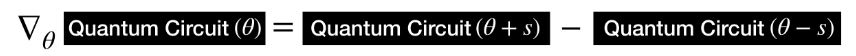

In [ ]:
# This class defines the operations that will be performed during the forward and backward pass of the Quantum layer
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input)
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = torch.Tensor()
        for i in range(len(input_list)):
          expectation_right = ctx.quantum_circuit.run(torch.Tensor([shift_right[i]] * (2*NUM_QUBITS)))
          expectation_left  = ctx.quantum_circuit.run(torch.Tensor([shift_left[i]] * (2*NUM_QUBITS)))

          gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
          gradients = torch.cat((gradients, gradient.float()))

        grad_output = np.array(grad_output).T
        result = torch.matmul(gradients.float(),torch.tensor(grad_output).float())
        return torch.flatten(result), None, None

# This class defines the Quantum layer to be interface with classical layer
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(NUM_QUBITS, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
# This class defines the complete Hybrid Quantum Neural Network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(2304, 8)
        self.fc2 = nn.Linear(8,8)
        self.hybrid = HybridFunction.apply#Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi*torch.tanh(x))
        self.fc3 = nn.Linear(16,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        #x = self.dropout(x)
        x = x.view(-1, 2304)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
       # x = np.pi*torch.tanh(x)
        x = self.hybrid(x[0], circuit, SHIFT)
        x = self.fc3(x.float())
        x = F.softmax(x, 1)
        return x

In [ ]:
print(Net())

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
# Function to yield the training or test data during the training and testing phase
def qc_data_loader(image_array, target_label, batch_size = 1, img_shape = (64, 64, 3)):
  input = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
  output = np.zeros((batch_size))

  while True:
    for i in range(batch_size):
      idx = random.randint(0, len(image_array)-1)
      input[i, ...] = np.transpose(image_array[idx])
      output[i] = target_label[idx]

    yield  torch.Tensor(input),  torch.Tensor(output).type(torch.LongTensor)

In [ ]:
# Intialize the generator which will be used later to iterate over the training and test data
train_loader = iter(qc_data_loader(training_data, training_labels))
test_loader = iter(qc_data_loader(testing_data, testing_labels))

In [ ]:
# Training the QCNN model
model = Net() # Instantiate the neural network model
optimizer = optim.Adam(model.parameters(), lr=0.001)   # Select the optimizer and set the learning rate
loss_func = nn.CrossEntropyLoss() # Select the loss function

epochs = 1  # Set the number of epochs
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for idx in range(10):              # len(training_labels)
      data, target = next(train_loader)
      optimizer.zero_grad()
      # Forward pass
      output = model(data)
      # Calculating loss
      loss = loss_func(output, target)
      # Backward pass
      loss.backward()
      # Optimize the weights
      optimizer.step()
      total_loss.append(loss.item())

    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

Text(0, 0.5, 'Cross Entropy Loss')

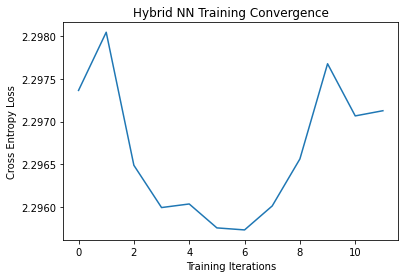

In [ ]:
# Plot the loss over epochs/ training iterations
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

In [ ]:
#Testing the model trained
model.eval()
with torch.no_grad():

    correct = 0
    for batch_idx in range(len(testing_labels)):
        data, target = next(test_loader)
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        print(pred)

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(sum(total_loss) / len(total_loss),correct / len(testing_labels) * 100))

tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor([[9]])
tensor

KeyboardInterrupt: ignored